# Complete System Model

### Imports

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
import math
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob
import timeit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

import os

In [2]:
# Files (Single Speaker)
down1 = glob('../input/audiodata2/AudioDat/Down/*.wav')
up1 = glob('../input/audiodata2/AudioDat/Up/*.wav')
no1 = glob('../input/audiodata2/AudioDat/No/*.wav')
yes1 = glob('../input/audiodata2/AudioDat/Yes/*.wav')
open1 = glob('../input/audiodata2/AudioDat/Open/*.wav')
close1 = glob('../input/audiodata2/AudioDat/Close/*.wav')

# (TF dataset 1000 per word)
Down = glob('../input/fullaudioset/mini_speech_commands/down/*.wav')
Go = glob('../input/fullaudioset/mini_speech_commands/go/*.wav')
Left = glob('../input/fullaudioset/mini_speech_commands/left/*.wav')
No = glob('../input/fullaudioset/mini_speech_commands/no/*.wav')
Right = glob('../input/fullaudioset/mini_speech_commands/right/*.wav')
Stop = glob('../input/fullaudioset/mini_speech_commands/stop/*.wav')
Up = glob('../input/fullaudioset/mini_speech_commands/up/*.wav')
Yes = glob('../input/fullaudioset/mini_speech_commands/yes/*.wav')

## Lets have a listen

In [3]:
ipd.Audio(Down[0])

# Create file list with labels

In [4]:
test_length = 800
one_speaker = [(down1,'down'),(up1,'up'),(no1,'no'),(yes1,'yes'),
               (open1,'open'),(close1,'close')]
part_test = [(Down[0:test_length],'down'),(Go[0:test_length],'go'),
             (Left[0:test_length],'left'),(No[0:test_length],'no'),
             (Right[0:test_length],'right'),(Stop[0:test_length],'stop'),
             (Up[0:test_length],'up'),(Yes[0:test_length],'yes')]
full_test = [(Down,'down'),(Go,'go'),(Left,'left'),(No,'no'),(Right,'right'),
             (Stop,'stop'),(Up,'up'),(Yes,'yes')]

# Feature Extractor

In [5]:
class features:
    def __init__( self, data, label = None ):
        
        #----Useful Information ---#
        self.data = data
        self.label = label
        self.raw = None
        self.sample_rate = None
        self.features = None # <---- features vector
        self.num_epochs = 13 #<---- define number of epochs
        
        
        
        #--- used for calculations between methods --#
        self.frame_width = None
        self.num_frames = None
        self.total_time = None
        self.freq_bins = None
        self.log_mel_spectrogram = None
        self.frame_samples = None
        self.tranform = None 


        
        #----debug individual feature outputs ---#
        self.zcr = None
        self.spec_centroid = None
        self.ber = None
        self.mfcc = None
        self.mfcc0 = None
        self.mfcc1 = None
        self.mfcc2 = None
        self.df = None

        
        #---setter --# (not currently useful)
        self.entry_point()
        

        
    def entry_point( self, frame = 1024, spacing = 512,bins = 32 ):
        raw,sr = librosa.load(self.data)
        self.raw = raw
        self.sample_rate = sr
        self.total_time = len(raw)/sr #total time duration
        self._gen_mel_spec( frame, spacing, bins )
        self.transform =librosa.stft(self.raw)
        self._get_zcr()
        self._get_mfcc0()
        self._get_mfcc1()
        self._get_mfcc2()
        self._get_ber()
        self._get_spectral_centroid()
        



        
    def cos_sim( self, sig0,sig1 ):
        s1,s2 = self._match_len2(sig0,sig1)
        return abs(np.dot(s1,s2)/(norm(s1)*norm(s2)))
    
    def correlate( self, sig0,sig1 ):
        s1,s2 = self._match_len2( sig0,sig1 )
        return np.correlate(s1,s2)
    
    def _concat_features(self, feature):
        self.features = np.hstack(
            [self.features, feature] if self.features is not None else feature
        )
        
    def _avg_epochs(self, arr):
        epochs = self.num_epochs
        epoch = []
        l = len(arr)
        epoch_length = int(np.floor( l/epochs ))
        for i in range(0,epochs):
            x = np.sum( arr[i*epoch_length: (i+1)*epoch_length])
            epoch.append(x)
        return epoch
        


    def _gen_mel_spec( self, frame,spacing, bins):
        mel_spectrogram = librosa.feature.melspectrogram(self.raw, sr=self.sample_rate,
                                                         n_fft=frame, hop_length=spacing, n_mels=bins)
        frame_width = self.total_time/mel_spectrogram.shape[1]
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
        self.frame_width = frame_width
        self.num_frames = log_mel_spectrogram.shape[1]
        self.freq_bins = log_mel_spectrogram.shape[0]
        self.log_mel_spectrogram = log_mel_spectrogram
        self.frame_samples = int(np.floor(len(self.raw)/self.num_frames))
        self.frame = [self.raw[m*self.frame_samples : (m+1)*self.frame_samples] for m in range(0,int(self.num_frames))]
        
 

    def _get_zcr( self ):
        signal = self.raw
        frame_size = self.frame_samples
        hop_length = int(np.floor(frame_size/2)) #overlap half the frame size
        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=frame_size, hop_length=hop_length)[0]
        self.zcr = self._avg_epochs(zcr)
#         self._concat_features(zcr)
        self._concat_features(self.zcr)

    def _get_spectral_centroid( self, frame_size = 1024, hop_length = 512):
        sc = librosa.feature.spectral_centroid(y=self.raw, sr=self.sample_rate, n_fft=frame_size, hop_length=hop_length)[0]
        self.spec_centroid = self._avg_epochs(sc)
#         self._concat_features(sc) #not useful for RF
        self._concat_features(self.spec_centroid)
       
        
    
    def _calculate_split_frequency_bin(self, split_frequency, num_frequency_bins):
        frequency_range = self.sample_rate / 2
        frequency_delta_per_bin = frequency_range / num_frequency_bins
        split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
        return int(split_frequency_bin)
    
    def _get_ber(self, split_frequency = 2000):
        spectrogram = self.transform
        split_frequency_bin = self._calculate_split_frequency_bin(split_frequency, len(self.transform[0]))
        band_energy_ratio = []

        # calculate power spectrogram
        power_spectrogram = np.abs(spectrogram) ** 2
        power_spectrogram = power_spectrogram.T

        # calculate BER value for each frame
        for frame in power_spectrogram:
            sum_power_low_frequencies = frame[:split_frequency_bin].sum()
            sum_power_high_frequencies = frame[split_frequency_bin:].sum()
            band_energy_ratio_current_frame = sum_power_low_frequencies / sum_power_high_frequencies
            band_energy_ratio.append(band_energy_ratio_current_frame)

        ber = np.array(band_energy_ratio)
        self.ber = self._avg_epochs(ber)
#         self._concat_features(ber)
        self._concat_features(self.ber)
    
    def _get_mfcc0( self ):
        signal = self.raw
        sample_rate = self.sample_rate
        mfcc = librosa.feature.mfcc(y=signal, n_mfcc=13, sr=sample_rate)
        self.mfcc = mfcc
        mfcc_mean = mfcc.mean(axis=1).T
        mfcc_std = mfcc.std(axis=1).T
        mfcc_feature = np.hstack([mfcc_mean, mfcc_std])
        self.mfcc0 = mfcc_feature
#         self._concat_features(mfcc_feature)
        self._concat_features(self.mfcc0)

    def _get_mfcc1( self ):
        mfcc = librosa.feature.delta(self.mfcc,order=1)
        mfcc_mean = mfcc.mean(axis=1).T
        mfcc_std = mfcc.std(axis=1).T
        mfcc_feature = np.hstack([mfcc_mean, mfcc_std])
        self.mfcc1 = mfcc_feature
#         self._concat_features(mfcc_feature)
        self._concat_features(self.mfcc1)
        
    def _get_mfcc2( self ):
        mfcc =librosa.feature.delta(self.mfcc,order=2)
        mfcc_mean = mfcc.mean(axis=1).T
        mfcc_std = mfcc.std(axis=1).T
        mfcc_feature = np.hstack([mfcc_mean, mfcc_std])
        self.mfcc2 = mfcc_feature
#         self._concat_features(mfcc_feature)
        self._concat_features(self.mfcc2)
        
        
        # Not currently used #
            
    def interp1d(self, array: np.ndarray, new_len: int) -> np.ndarray:
        la = len(array)
        return np.interp(np.linspace(0, la - 1, num=new_len), np.arange(la), array)

    def _match_len2( self, sig0, sig1 ):
        #interpolates to match two vectors in length
        L = (len(sig0),len(sig1)) #find the longest length
        la = np.max(L)
        s0 = self.interp1d(sig0, la)
        s0 = s0/np.linalg.norm(s0)
        s1 = self.interp1d(sig1, la)
        s1 = s1/np.linalg.norm(s1)
        return s0,s1

        

# Feature DF Builder
Takes the list of files and creates features from feature extractor

In [6]:
def df_builder(lst):
    df = None
    for touple in lst:
        word,label = touple
        print(f'working on {label}')
        for test in word:
            x = features(test,label) # create feature class
#             xx = np.hstack([x.zcr,x.ber, x.mfcc0,x.mfcc1,x.mfcc2]) #specific features
            xx = x.features #access all features
            if isinstance(df, pd.core.frame.DataFrame ):
                df = pd.concat([df, pd.DataFrame(xx).T],ignore_index = True)
                df['label'].iloc[-1] = x.label
            else:
                df = pd.DataFrame(xx).T
                df['label'] = x.label

    return df

# Single df builder for testing against new inputs
def quick_builder( audio, label ):
    audio_features = features( audio,label )
    audio_df = pd.DataFrame( audio_features.features).T
    audio_df['label'] = label
    return audio_df

# RUN:

## Run Single Speaker, TF Data, or read from .csv

In [7]:
## Single Speaker (Small RunTime)

In [8]:
start = timeit.default_timer()
df_one_speaker = df_builder(one_speaker)
stop = timeit.default_timer()
print(f'Time to compute: {np.round((stop-start) /60,2)} mins') 
print(f'found {df_one_speaker.isnull().sum().sum()} NaN or empty values this cycle')

working on down
working on up
working on no
working on yes
working on open
working on close
Time to compute: 0.44 mins
found 0 NaN or empty values this cycle


In [9]:
## TF Database (approx 15minute runtime)

In [10]:
start = timeit.default_timer()
df = df_builder(full_test)
stop = timeit.default_timer()
print(f'Time to compute: {np.round((stop-start) /60,2)} mins') 
print(f'found {df.isnull().sum().sum()} NaN or empty values this cycle')

working on down
working on go
working on left
working on no
working on right
working on stop
working on up
working on yes
Time to compute: 11.56 mins
found 411 NaN or empty values this cycle


## Or load the pregenerated DFs from csv

In [11]:
# tensors = glob('./*.csv')
# df_one_speaker = pd.read_csv(tensors[0])
# df = pd.read_csv(tensors[1])
# df_one_speaker.head()

### Split the words

In [12]:
df_up = df.loc[df.label =='up']
df_down = df.loc[df.label=='down']

df_left = df.loc[df.label =='left']
df_right = df.loc[df.label =='right']

df_go = df.loc[df.label =='go']
df_stop = df.loc[df.label =='stop']

df_no = df.loc[df.label =='no']
df_yes = df.loc[df.label =='yes']

In [13]:
df_2_words = pd.concat([df_down, df_up],ignore_index = True)
df_4_words = pd.concat([df_down, df_up,df_yes,df_no],ignore_index = True)
df_6_words = pd.concat([df_down, df_up,df_yes,df_no,df_left,df_right],ignore_index = True)

# Build Random Forest Model

In [14]:
def ran_for(df,split =0.2):
    impute = SimpleImputer()
    df.label = df['label']
#     df['label'] = df.label
    labs =df.label.unique()
    df2 = impute.fit_transform(df.drop(['label'],axis='columns')) ## Protect against Null
    X_train, X_test, y_train, y_test = train_test_split(df2,df.label,test_size = split)
    print(f'Reserved test data: {len(X_test)}')
    test = len(X_train)
    #build the model
    model = RandomForestClassifier( n_estimators=300 )
    model.fit(X_train, y_train)
    scr = np.round(model.score( X_test,y_test),2 )*100
    print(f'Average score: {scr}')
    print(f'Words: {[x for x in labs]}')
    #creat matrix of tests
    y_predicted = model.predict(X_test)
    cm = confusion_matrix(y_test,y_predicted)
    fig,ax = plt.subplots(1,1,figsize=(12,12))
    sns.heatmap(cm,annot=True)
    ax.set_xlabel('Prediction')
    ax.set_xticklabels(labs)
    ax.set_yticklabels(labs)
    ax.set_ylabel('Ground Truth')
    ax.set_title(f'Accuracy of {len(labs)} words based: {scr}%, trained on {test} files')
    
    return model
    

# Results

### One Speaker

Reserved test data: 37
Average score: 100.0
Words: ['down', 'up', 'no', 'yes', 'open', 'close']


RandomForestClassifier(n_estimators=300)

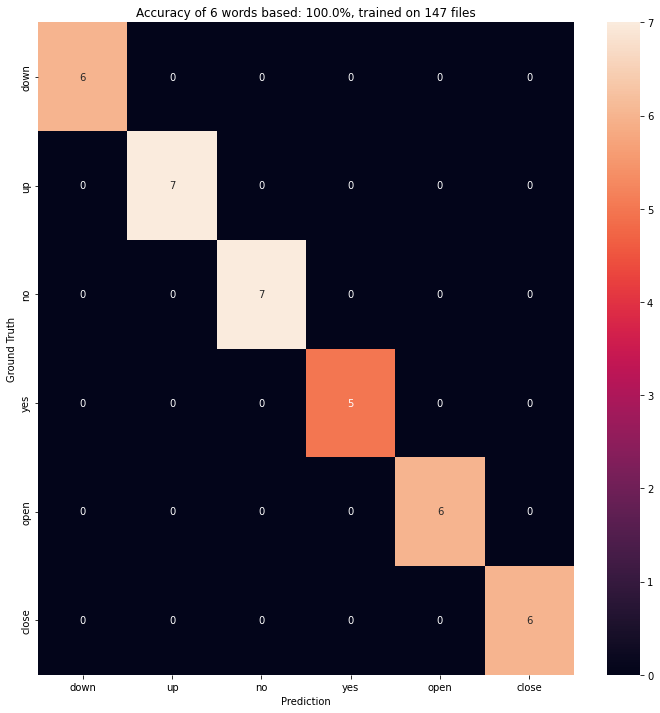

In [15]:
ran_for(df_one_speaker)

### TF Data: Multiple Speakers

Reserved test data: 400
Average score: 91.0
Words: ['down', 'up']


RandomForestClassifier(n_estimators=300)

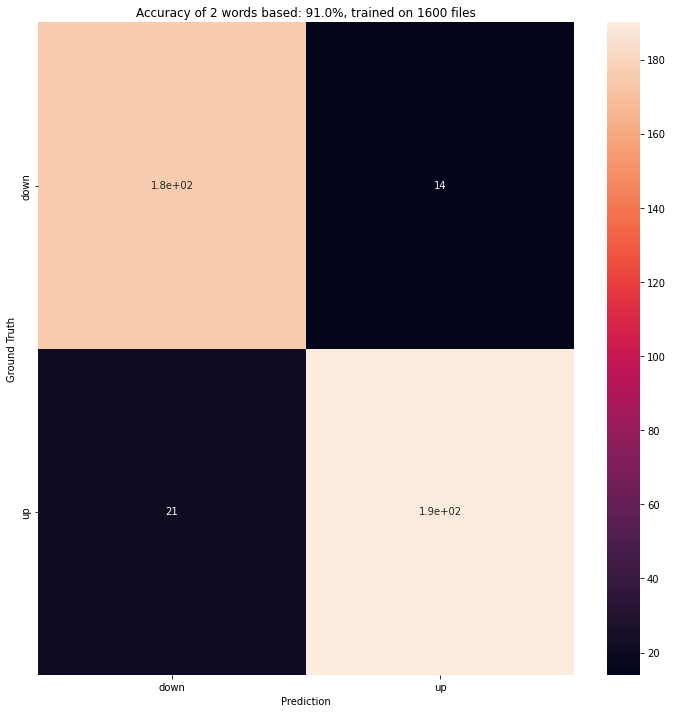

In [16]:
ran_for(df_2_words)

Reserved test data: 800
Average score: 83.0
Words: ['down', 'up', 'yes', 'no']


RandomForestClassifier(n_estimators=300)

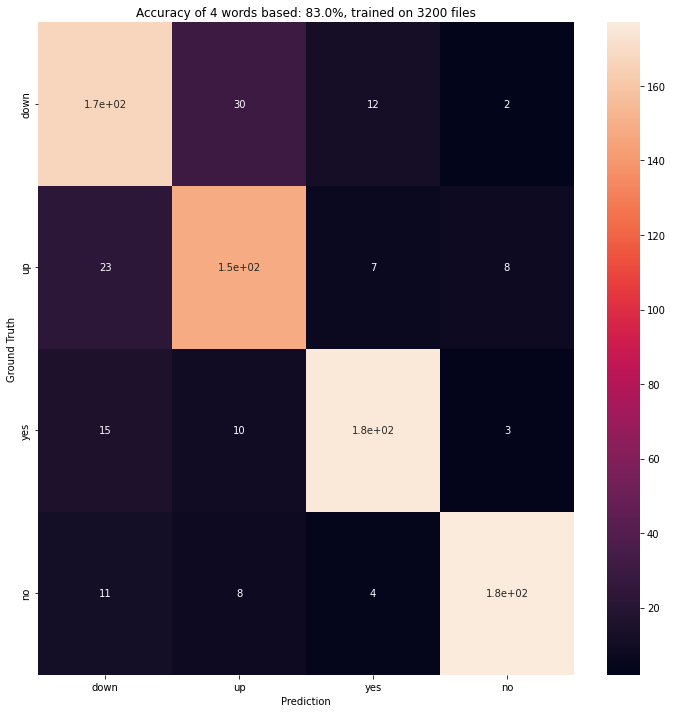

In [17]:
ran_for(df_4_words)

Reserved test data: 1200
Average score: 71.0
Words: ['down', 'up', 'yes', 'no', 'left', 'right']


RandomForestClassifier(n_estimators=300)

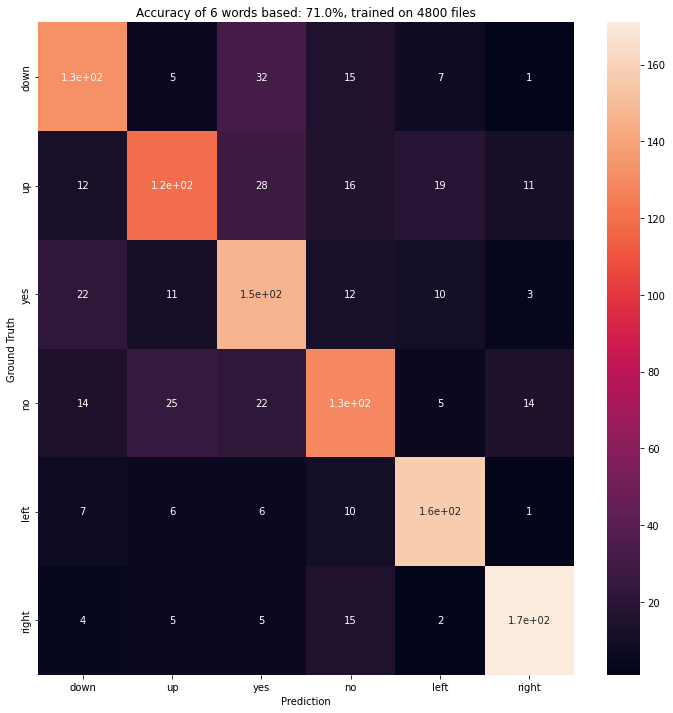

In [18]:
ran_for(df_6_words)

Reserved test data: 1600
Average score: 68.0
Words: ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']


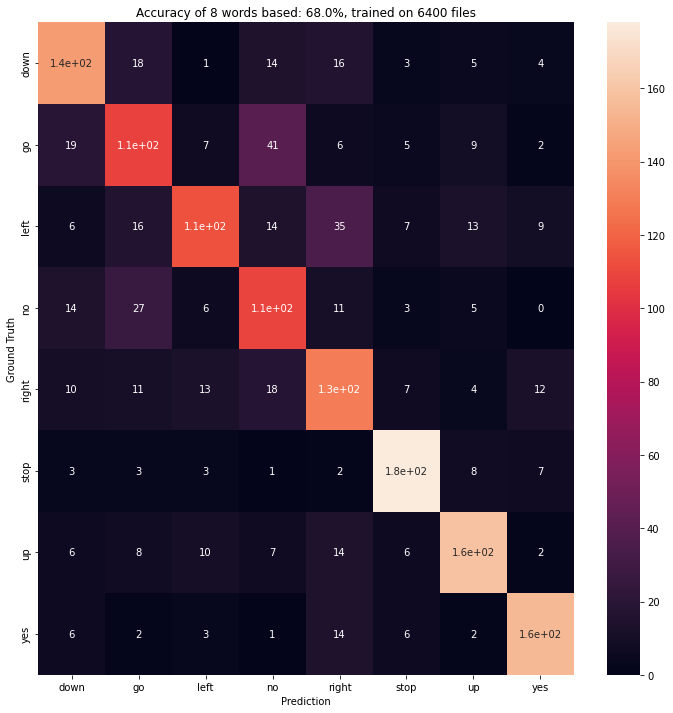

In [19]:
model = ran_for(df,0.2)

### Export dfs

In [20]:
df_one_speaker.to_csv('FeatureVector_OS_data.csv',index=False)
df.to_csv('FeatureVector_TF_data.csv',index=False)

# Test the model!
___

### Use the single speaker inputs against the TF trained set

In [21]:
def single_test(df,model):
    impute = SimpleImputer()
    df.label = df['label']
    df2 = impute.fit_transform(df.drop(['label'],axis='columns')) ## Protect against Null
    y_predicted = model.predict(df2)
    return y_predicted

In [22]:
### Testing against single speaker inputs

In [23]:
test = quick_builder(up1[0], 'up')
lab =test.loc[0,'label']
print(f'Input is {lab}, prediction is: {single_test(test,model)}')

Input is up, prediction is: ['up']


# Show the features:
___

In [24]:
u_feat = features(Up[0],'Up')
d_feat = features(Down[0],'Down')
y_feat = features(Yes[0],'Yes')
n_feat = features(No[0],'No')
words = [u_feat,d_feat,y_feat,n_feat]

### MFCCS:
MFCCs used in the feature vectors take the average across the bins for comparison,
They show the power of the formants across each acoustic frame

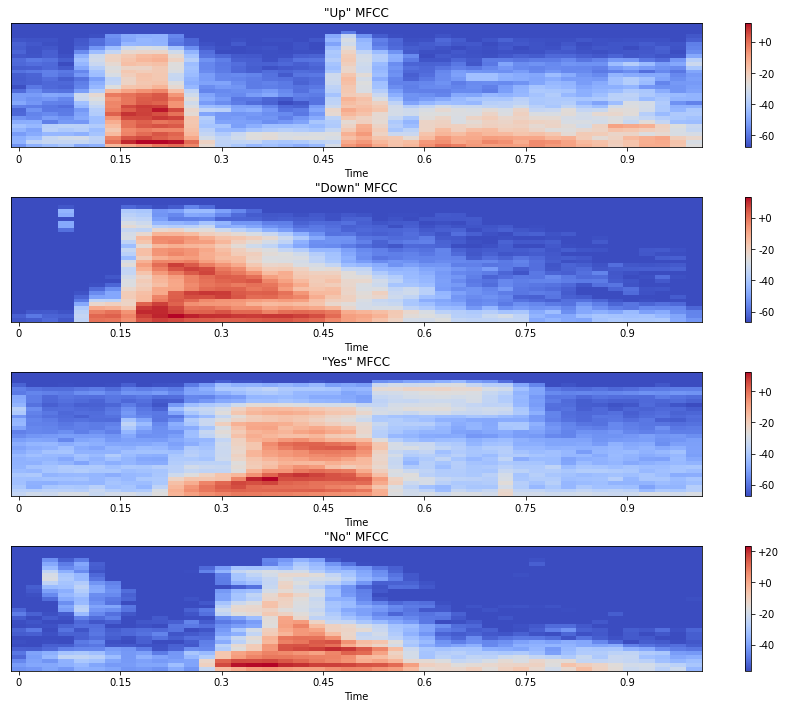

In [25]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1.0,
                    wspace=0.4,
                    hspace=0.4)
for i,word in enumerate(words):
    if i == 0:
        ax = plt.subplot(4, 1, i+1)

    else:
        plt.subplot(4, 1, i+1)
    librosa.display.specshow(word.log_mel_spectrogram, 
                         x_axis="time", 
                         sr=word.sample_rate)
    plt.colorbar(format="%+2.f")
    plt.title(f'"{word.label}" MFCC')

plt.show()

# Spectral Centroids: 
### Shows where the highest concentration of energy is across frequency bins

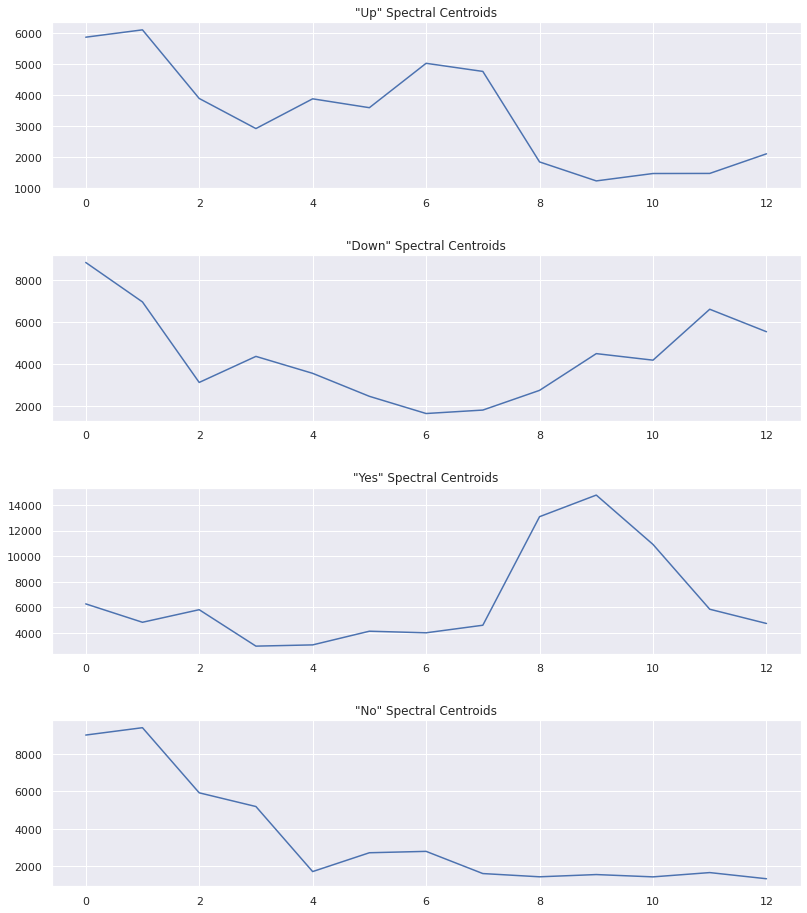

In [26]:
sns.set_theme()
plt.figure(figsize=(13, 15))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
for i,word in enumerate(words):
    if i == 0:
        ax = plt.subplot(4, 1, 1)
    else:
        plt.subplot(4, 1, i+1)
    plt.plot(word.spec_centroid, color='b')
    plt.title(f'"{word.label}" Spectral Centroids')
plt.show()

# Band Energy Ratio:
### Shows the ratio of spectral energy split above and below 2khz, Useful for finding plosive phonemes

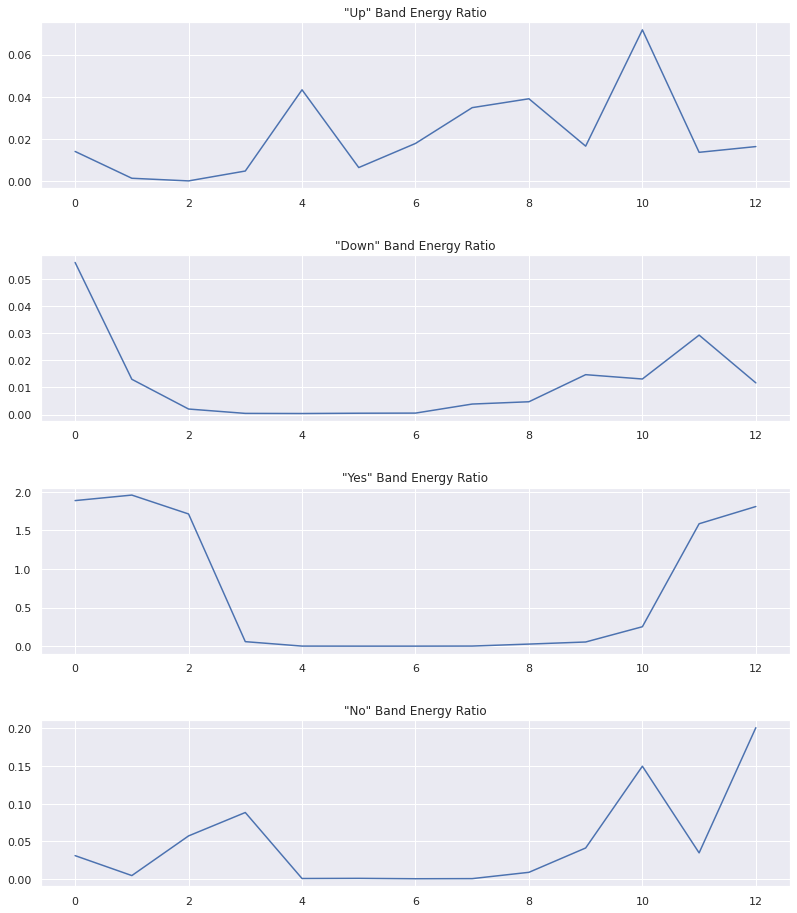

In [27]:
sns.set_theme()
plt.figure(figsize=(13, 15))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
for i,word in enumerate(words):
    if i == 0:
        ax = plt.subplot(4, 1, 1)
    else:
        plt.subplot(4, 1, i+1)
    plt.plot(word.ber, color='b')
    plt.title(f'"{word.label}" Band Energy Ratio')
plt.show()

# Zero Crossing Rate:
### This feature is especially good at separating plosives, and 'S' phonemes.

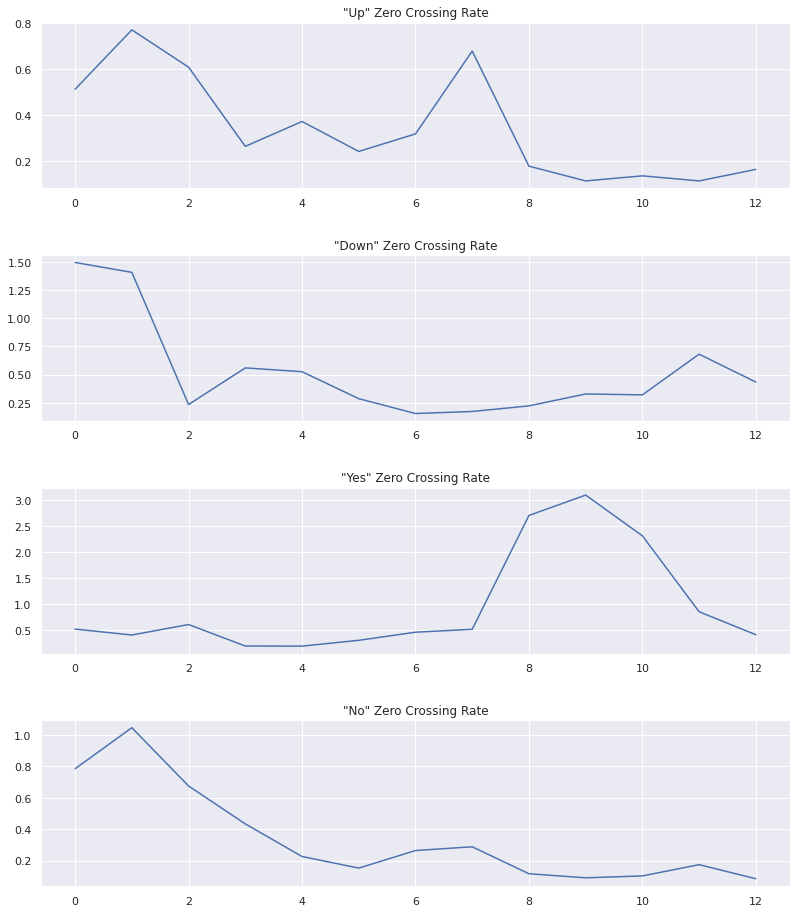

In [28]:
sns.set_theme()
plt.figure(figsize=(13, 15))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
for i,word in enumerate(words):
    if i == 0:
        ax = plt.subplot(4, 1, 1)
    else:
        plt.subplot(4, 1, i+1)
    plt.plot(word.zcr, color='b')
    plt.title(f'"{word.label}" Zero Crossing Rate')
plt.show()

### Code references

In [29]:
'''
https://www.tensorflow.org/tutorials/audio/simple_audio
https://github.com/codebasics/py/blob/master/ML/11_random_forest/11_random_forest.ipynb
https://github.com/musikalkemist/AudioSignalProcessingForML
https://github.com/marcmuon/urban_sound_classification/blob/master/audio.py
'''

'\nhttps://www.tensorflow.org/tutorials/audio/simple_audio\nhttps://github.com/codebasics/py/blob/master/ML/11_random_forest/11_random_forest.ipynb\nhttps://github.com/musikalkemist/AudioSignalProcessingForML\nhttps://github.com/marcmuon/urban_sound_classification/blob/master/audio.py\n'